<img src = "NetworkSnapshot.svg" width="25%">

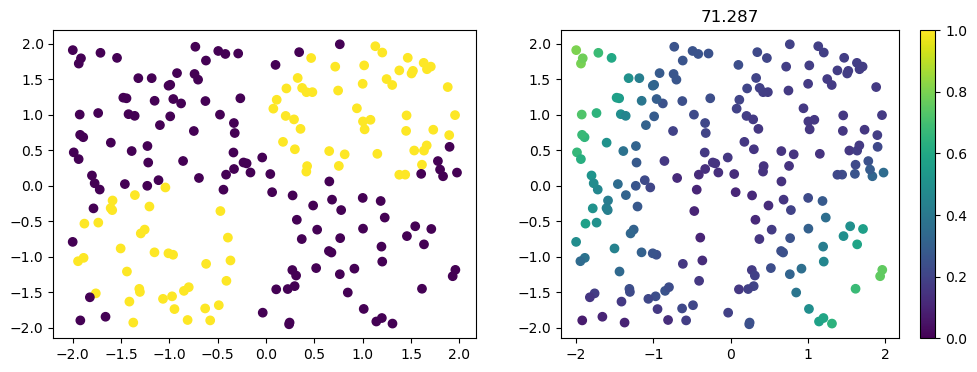

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def logistic(u):
    return 1/(1+np.exp(-u))

def leaky_relu(u, alpha=0.01):
    ret = u
    ret[u < 0] *= alpha
    return ret

def nn_forward(layers, x):
    """
    Evaluate a feedforward neural network

    Parameters
    ----------
    layers: list of (ndarray(N_{i+1}, Ni), ndarray(N_{i+1}, 1), function)
        List of (weights, bias, nonlinear function) to apply at each layer
    x: ndarray(N_0, n_examples)
        Input
      
    Returns
    -------
    ndarray
        Result of neural network evaluation
    """
    ## Evaluate the neural network on an input x
    y = x.T
    ## TODO: Fill this in
    for [W, b, f] in layers:
        y = f(W.dot(y) + b)
    return y


def get_loss(xs, ys, layers):
    """
    Given a bunch of example input/output pairs (xs[i], ys[i])
    
    Compute the loss of my model (Ws, bs)
    """
    y_est = nn_forward(layers, xs)
    return np.sum((ys-y_est)**2)
    

def get_derivatives(xs, ys, layers, h=1e-5):   
    ## Derivative of a function is
    ## lim h->0 (f(x + h) - f(x))/h
    ## Secant approximation (f(x + h) - f(x))/h
    
    ## TODO: Estimate the derivative of the loss function
    ## with respect to each weight and each bias
    loss = get_loss(xs, ys, layers) # f(x)
    Ws_deriv = [0*W for [W, _, _] in layers]
    bs_deriv = [0*b for [_, b, _] in layers]
    
    for i in range(len(layers)):
        [W, b, _] = layers[i]
        for row in range(W.shape[0]):
            for col in range(W.shape[1]):
                temp = W[row][col]
                W[row][col] += h
                loss_after = get_loss(xs, ys, layers)
                Ws_deriv[i][row][col] = (loss_after - loss)/h
                W[row][col] = temp
            temp = b[row]
            b[row] += h
            loss_after = get_loss(xs, ys, layers)
            bs_deriv[i][row] = (loss_after - loss)/h
            b[row] = temp
    return Ws_deriv, bs_deriv
    
    

np.random.seed(1)
"""
xs = np.random.randn(200, 2)
r = np.sqrt(np.sum(xs**2, axis=1))
ys = 1.0*(r > 1)
xs[r > 1] *= 1.5
"""

xs = np.random.rand(200, 2)*4 - 2
r1 = np.sqrt(np.sum((xs-np.array([[1, 1]]))**2, axis=1))
r2 = np.sqrt(np.sum((xs-np.array([[-1, -1]]))**2, axis=1))
ys = 1.0*(((r1 <= 1) + (r2 <= 1)) >= 1)


n_inner = 10 # Number of neurons in the first hidden layer

# Each layer is a list of [Weights, biases, function handle to activtion]

layers = [
    [np.random.randn(n_inner, 2), np.random.randn(n_inner, 1), leaky_relu],
    [np.random.randn(5, n_inner), np.random.randn(5, 1), leaky_relu],
    [np.random.randn(1, 5), np.random.randn(1, 1), logistic]
]

y_est = nn_forward(layers, xs)

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.scatter(xs[:, 0], xs[:, 1], c=ys)
plt.subplot(122)
plt.scatter(xs[:, 0], xs[:, 1], c=y_est, vmin=0, vmax=1)
plt.title("{:.3f}".format(get_loss(xs, ys, layers)))
plt.colorbar()

67.72450961120163
8.24777284340869
6.657707768208031
5.546826872311502
5.007721383124803
4.719977368573893
4.853747234420373
4.681538819300266
4.019954331321852
4.038310868181007
4.119052540624178
3.5657502267540666
3.3166023002385225
3.123482745092798
3.6735291079204337
3.83189671157656
2.2408672276296855
2.2901358387051967
1.509253696985092
1.5391705846920718


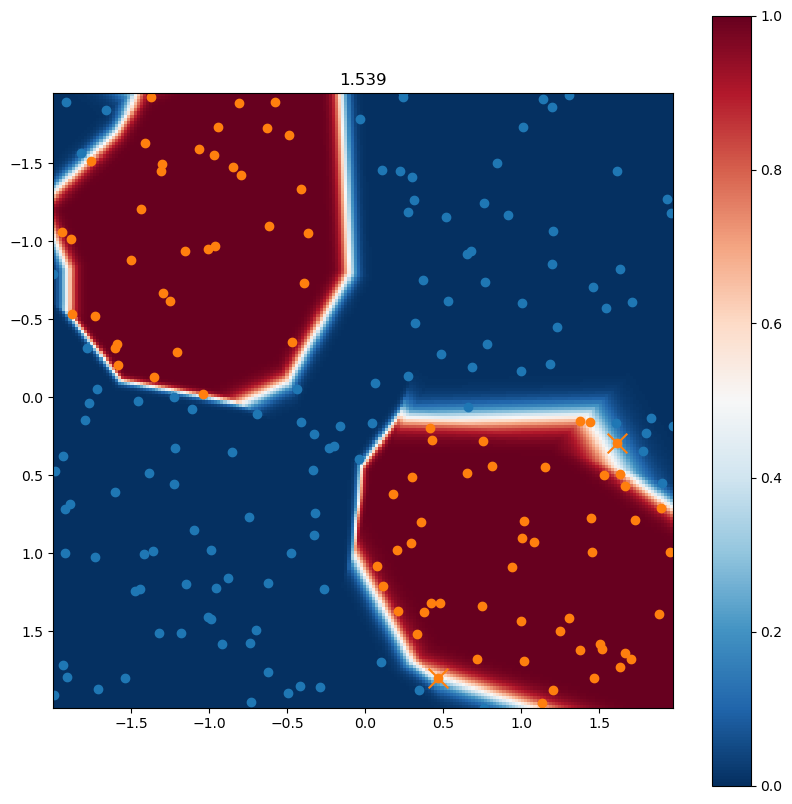

In [16]:
alpha = 1e-3


xmin = np.min(xs, axis=0)
xmax = np.max(xs, axis=0)
resol = 200
xx = np.linspace(xmin[0], xmax[0], resol)
yy = np.linspace(xmin[1], xmax[1], resol)
xx, yy = np.meshgrid(xx, yy)

plt.figure(figsize=(10, 10))
n_epochs = 20000
losses = np.zeros(n_epochs)
for epoch in range(n_epochs):
    Ws_deriv, bs_deriv = get_derivatives(xs, ys, layers)
    ## Update our weights based on the derivatives
    for i in range(len(layers)):
        layers[i][0] -= alpha*Ws_deriv[i]
        layers[i][1] -= alpha*bs_deriv[i]
    loss = get_loss(xs, ys, layers)
    losses[epoch] = loss
    if epoch%1000 == 0:
        print(loss)
        plt.clf()
        grid_eval = nn_forward(layers, np.array([xx.flatten(), yy.flatten()]).T)
        plt.imshow(np.reshape(grid_eval, xx.shape), cmap='RdBu_r', 
                   extent=(xmin[0], xmax[0], xmax[1], xmin[1]),
                   vmin=0, vmax=1)
        plt.colorbar()
        plt.scatter(xs[ys == 0, 0], xs[ys == 0, 1], c='C0')
        plt.scatter(xs[ys == 1, 0], xs[ys == 1, 1], c='C1')

        ys_est = np.round(nn_forward(layers, xs)).flatten()
        idx = (ys == 0)*(ys_est == 1)
        incorrect = np.sum(idx)
        plt.scatter(xs[idx == 1, 0], xs[idx == 1, 1], c='C0', s=200, marker='x')
        idx = (ys == 1)*(ys_est == 0)
        incorrect += np.sum(idx)
        plt.scatter(xs[idx == 1, 0], xs[idx == 1, 1], c='C1', s=200, marker='x')
        plt.title("{:.3f}".format(loss))
        plt.savefig("{}.png".format(epoch))